In [1]:
import cv2
from matplotlib import pyplot as plt

# Display original image

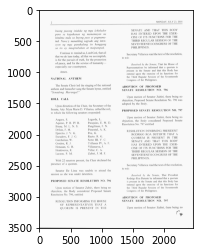

In [2]:
image = cv2.imread('journal-1-p1.png')
plt.imshow(image)

# Get the grayscale of the image

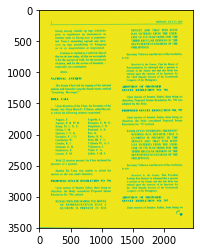

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

# Setup various preprocessing algorithms

In [4]:
import numpy as np

def original(img):
    return image

def grayscale(img):
    return gray

def remove_noise(img):
    return cv2.medianBlur(img, 5)


def thresholding(img):
    return cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


def dilate(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(img, kernel, iterations=1)


def erode(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.erode(img, kernel, iterations=1)


def opening(img):
    """Opening - erosion followed by dilation"""
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)


def canny(img):
    return cv2.Canny(img, 100, 200)


preprocessors = [
    original,
    grayscale,
    remove_noise,
    thresholding,
    dilate,
    erode,
    opening,
    canny,
]

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid


def new_grid(item_count):
    columns = 2
    rows = int(item_count / columns) + 1
    return ImageGrid(
        plt.figure(figsize=(60, 60)),
        111,
        nrows_ncols=(rows, columns),
        axes_pad=1)

# Apply preprocessing to our image

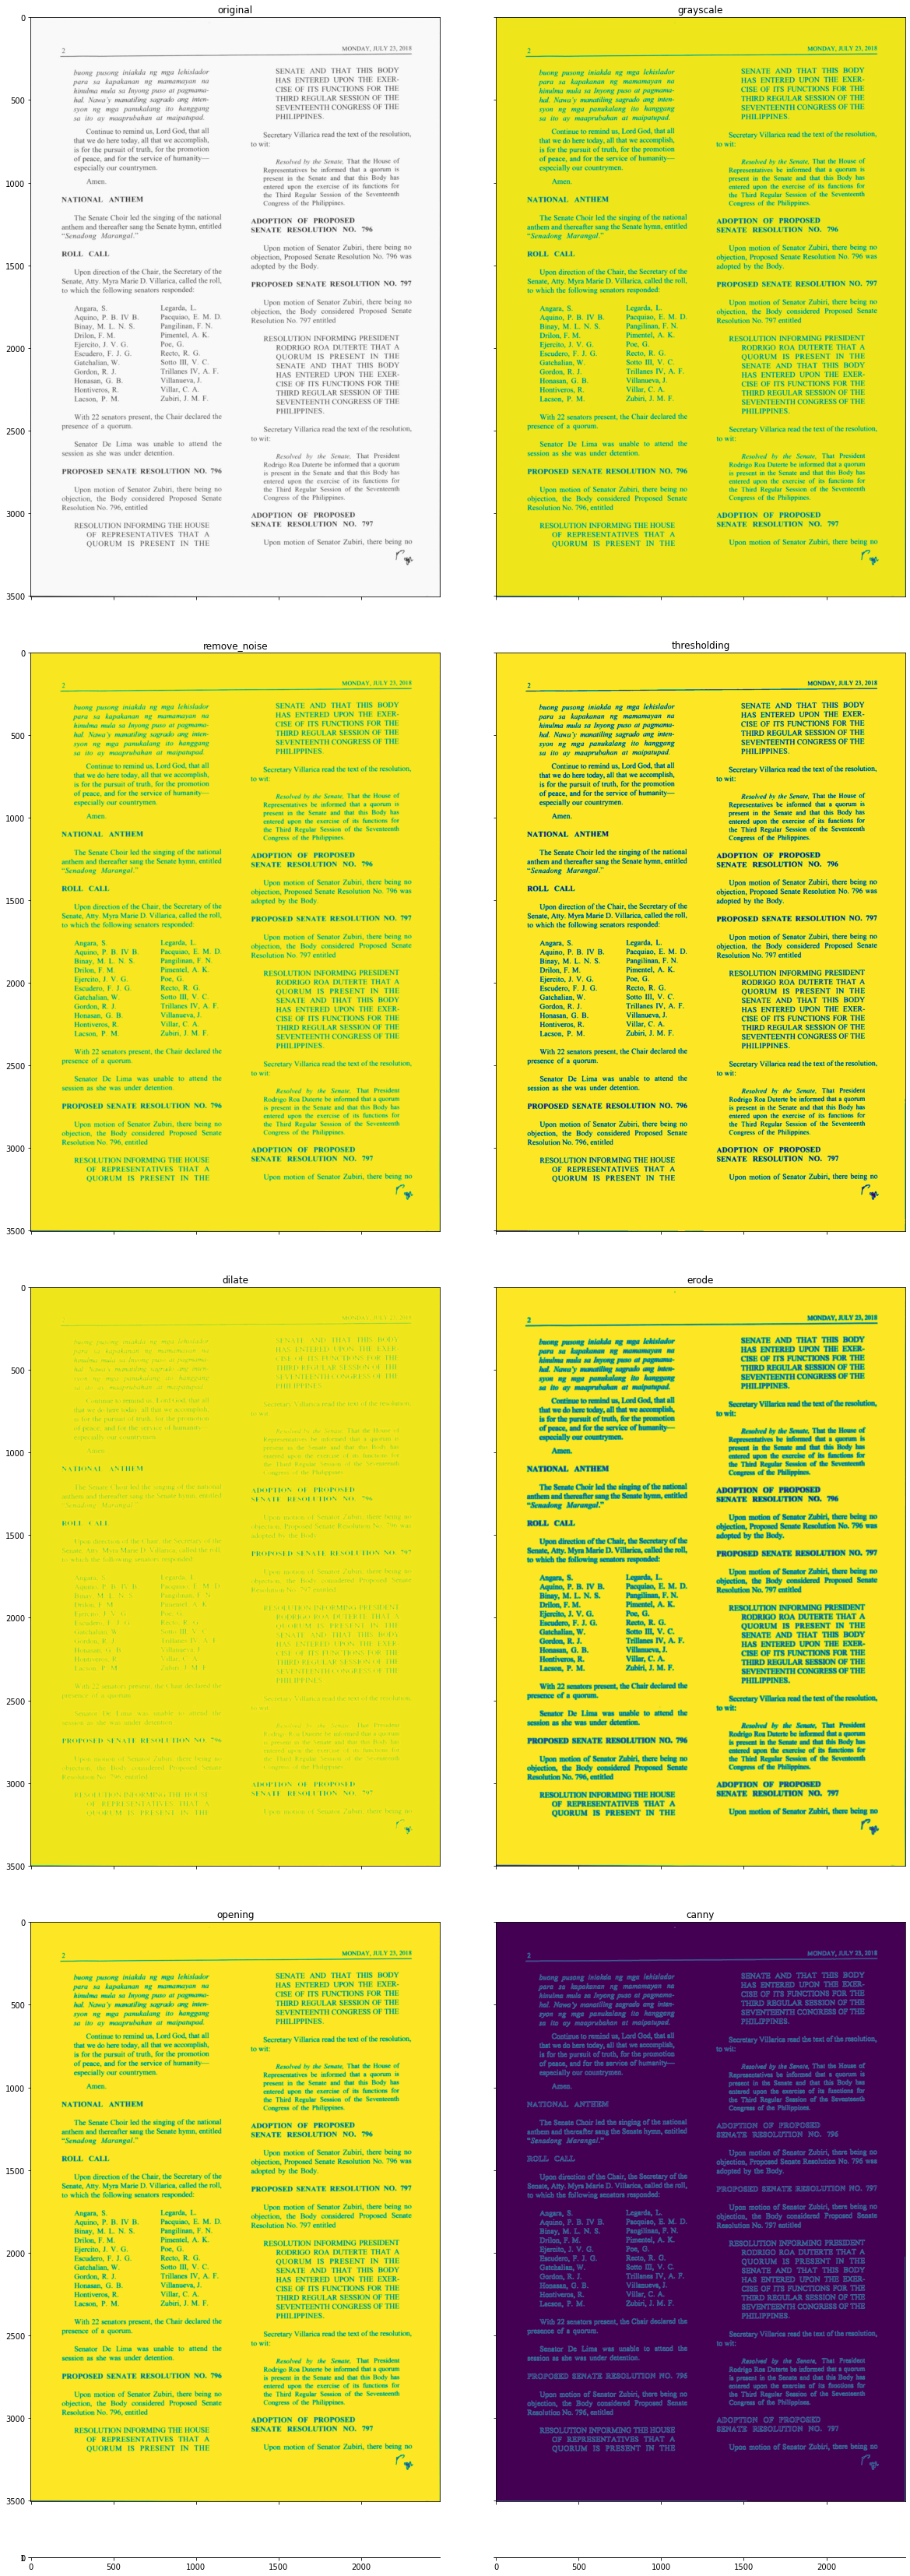

In [6]:
grid = new_grid(len(preprocessors))

preprocessed = {}
for ax, preprocess in zip(grid, preprocessors):
    key = preprocess.__name__
    preprocessed[key] = preprocess(gray)

    ax.set_title(key)
    ax.imshow(preprocessed[key])

plt.show()

# Layout Detection

In [7]:
import layoutparser.models as lpmodel

model = lpmodel.Detectron2LayoutModel(
    config_path='lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',  # In model catalog
    label_map={0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"},  # In model`label_map`
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5]  # Optional
)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


/home/devcsrj/.local/share/virtualenvs/klerk-6P6mTcQK/lib/python3.8/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/devcsrj/.local/share/virtualenvs/klerk-6P6mTcQK/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


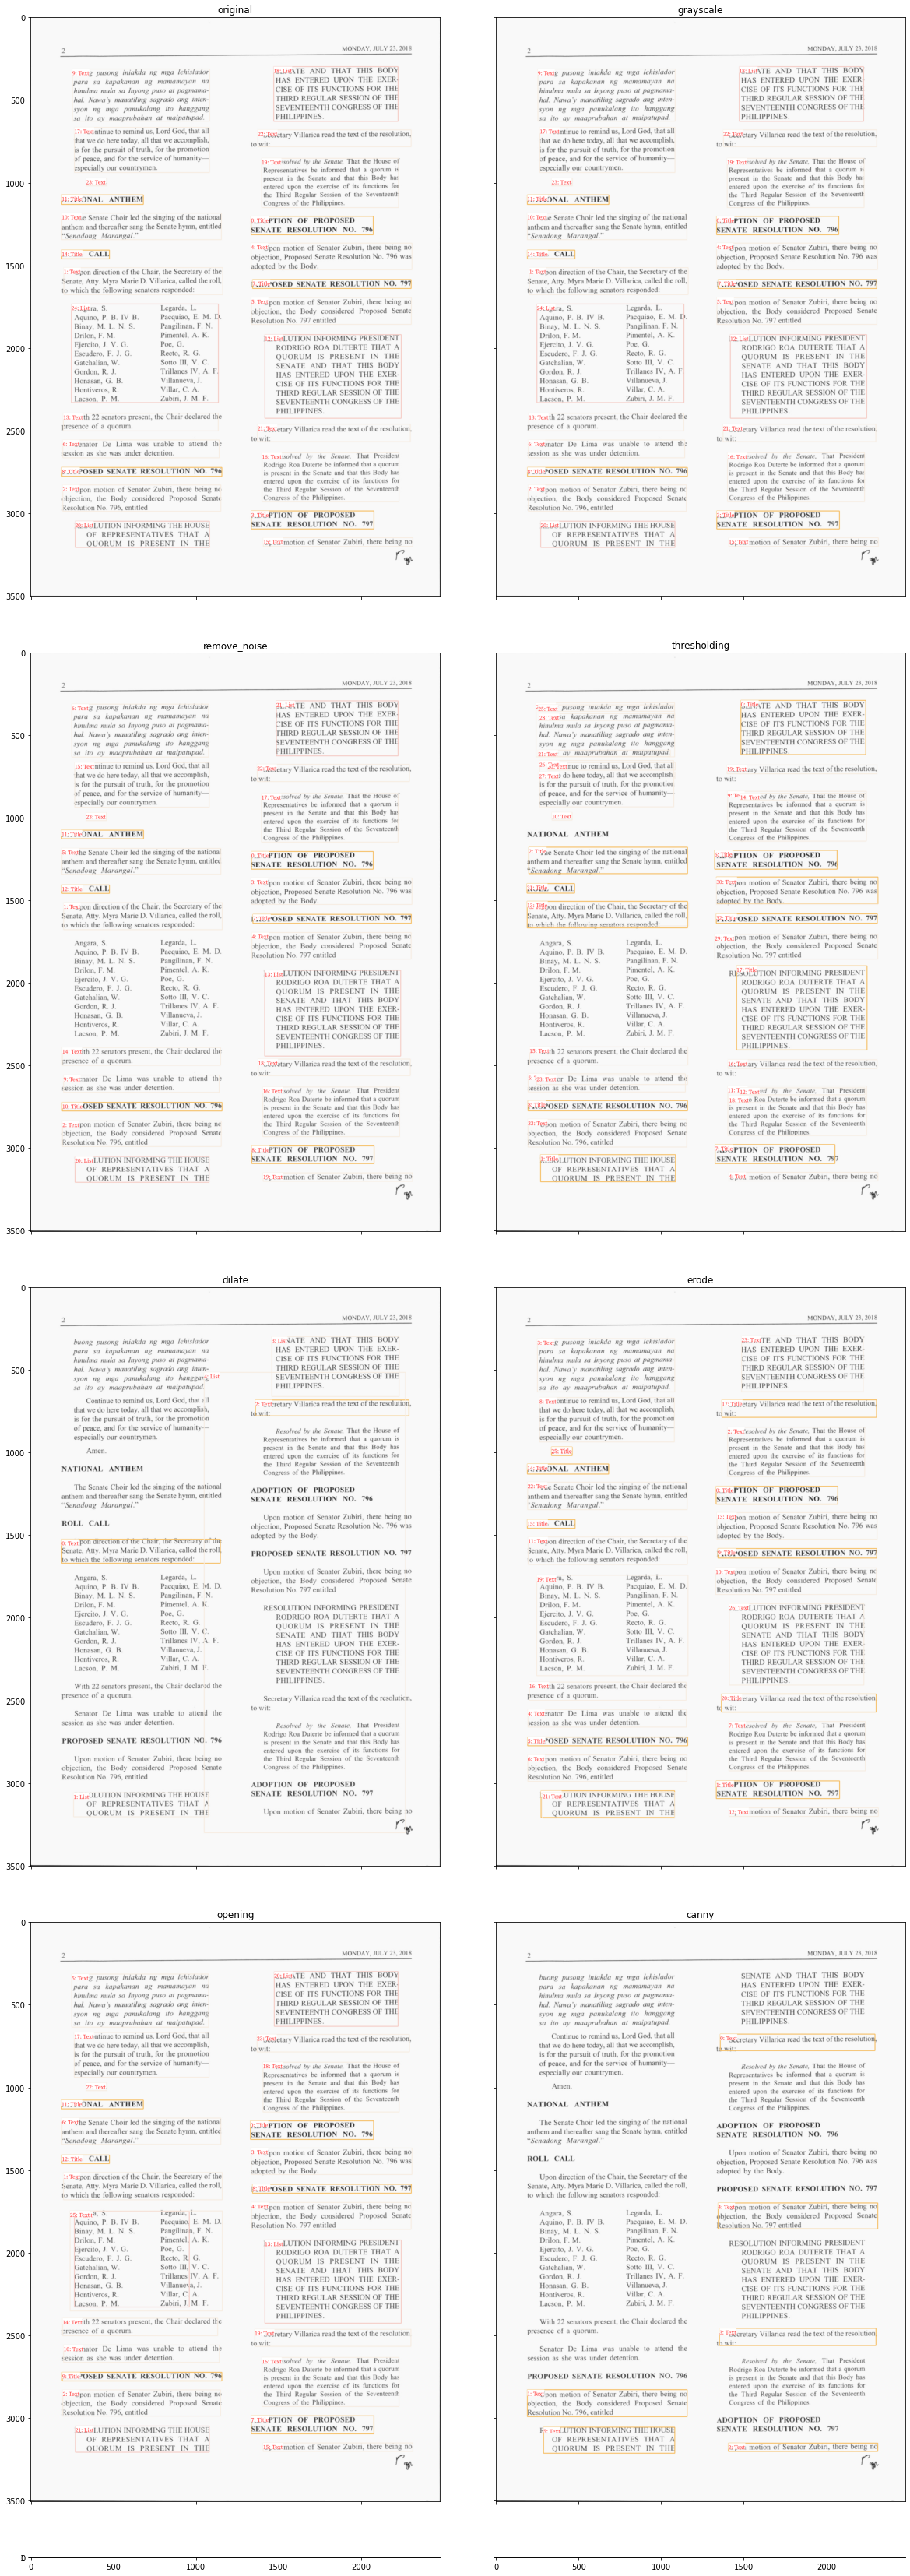

In [8]:
import layoutparser.visualization as lpviz
from PIL import Image

layouts = {}
for alg, img in preprocessed.items():
    layouts[alg] = model.detect(Image.fromarray(img))

grid = new_grid(len(layouts))
for ax, layout in zip(grid, layouts.items()):
    drawn = lpviz.draw_box(
        image,
        layout[1],
        box_width=5,
        id_font_size=32,
        id_text_color='red',
        show_element_id=True,
        show_element_type=True)
    ax.set_title(layout[0])
    ax.imshow(drawn)

plt.show()

# Block count

In [9]:
for key, layout in sorted(layouts.items(), key=lambda kv: (kv[1], kv[0])):
    print(key, len(layout._blocks))


canny 6
dilate 5
erode 27
grayscale 25
opening 26
original 25
remove_noise 24
thresholding 34
